In [1]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt

# Support Vector Machine

In [2]:
# Define kernels

def linear_kernel(**kwargs):
    def f(x1, x2):
        return np.inner(x1, x2)
    return f

def polynomial_kernel(power, coef, **kwargs):
    def f(x1, x2):
        return (np.inner(x1, x2) + coef)**power
    return f

def rbf_kernel(gamma, **kwargs):
    def f(x1, x2):
        distance = np.linalg.norm(x1 - x2)**2
        return np.exp(-gamma * distance)

In [21]:
import cvxopt

class SupportVectorMachine(object):
    """Support vector classifier
    Parameters
    ----------
    C: float
        Penalty term
    kernel: function
        Kernel function (linear, gaussian, polynomial)
    gamma: float
    power: int
    coef: float
        Bias term in polynomial function
    """
    def __init__(self, C=1, kernel=rbf_kernel, power=4, gamma=None, coef=4):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.power = power
        self.coef = coef
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vectors_labels = None
        self.intercept = None
    
    def fit(self, x, y):
        """Find SVM parameters
        (Lagrange multipliers, corresponding support vectors)
        """
        n_samples, n_features = np.shape(x)

        if not self.gamma:
            self.gamma = 1/n_features
        
        # Instantiate kernel
        self.kernel = self.kernel(
            power = self.power,
            coef = self.coef,
            gamma = self.gamma
        )

        # Find kernel matrix
        kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i, j] = self.kernel(x[i], x[j])
        
        # Solve the quadratic optimization problem using cvxopt package
        # [TODO: Understand how to formulate QP optimisation]
        P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')

        if not self.C:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            h_max = cvxopt.matrix(np.zeros(n_samples))
            h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
            h = cvxopt.matrix(np.vstack((h_max, h_min)))

        # Solve the quadratic optimization problem using cvxopt
        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)
        lagr_multipliers = np.ravel(minimization['x'])

        # Select non-zero lagr_multipliers (alpha)
        idx = lagr_multipliers > 1e-7
        self.lagr_multipliers = lagr_multipliers[idx]
        # Select corresponding support vectors and y labels
        self.support_vectors = x[idx]
        self.support_vectors_labels = y[idx]

        # Calculate intercept (TODO: How?)
        self.intercept = self.support_vectors_labels[0]
        for i in range(len(self.lagr_multipliers)):
            self.intercept -= self.lagr_multipliers[i] * self.support_vectors_labels[
                i] * self.kernel(self.support_vectors[i], self.support_vectors[0])
    
    def predict(self, x):
        """ Get SVM prediction
        (Weighted (lagr_multipliers) sum of kernel outputs with support vectors)
        """
        y_pred = []
        for sample in x:
            pred = 0
            # Iterate over support vectors
            for i in range(len(self.lagr_multipliers)):
                pred += self.lagr_multipliers[i] * self.support_vectors_labels[
                    i] * self.kernel(self.support_vectors[i], sample)
            pred += self.intercept
            y_pred.append(np.sign(pred))
        return np.array(y_pred)


     pcost       dcost       gap    pres   dres
 0: -1.7549e+01 -1.2988e+02  5e+02  2e+00  1e-14
 1: -1.2056e+01 -7.4828e+01  6e+01  3e-16  1e-14
 2: -1.5831e+01 -2.4167e+01  8e+00  2e-16  1e-14
 3: -1.8827e+01 -2.0623e+01  2e+00  2e-16  1e-14
 4: -1.9479e+01 -1.9898e+01  4e-01  2e-16  1e-14
 5: -1.9650e+01 -1.9723e+01  7e-02  4e-16  1e-14
 6: -1.9683e+01 -1.9688e+01  4e-03  4e-16  1e-14
 7: -1.9685e+01 -1.9685e+01  1e-04  4e-16  2e-14
 8: -1.9685e+01 -1.9685e+01  1e-06  4e-16  1e-14
Optimal solution found.
Accuracy: 0.9090909090909091


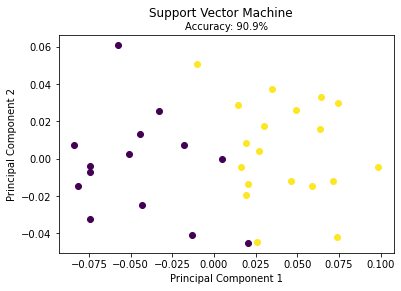

In [22]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

def normalize(X, axis=-1, order=2):
    """Normalise the dataset (unit norm)
        Axis:0 => Each feature(column) is normalised to unit norm
        Axis:1 => Each sample(row) is normalised to unit norm
        X = X / sqrt(sum|X|^2)
    """
    norm = np.atleast_1d(np.linalg.norm(X, ord=order, axis=axis))
    norm[norm == 0] = 1
    return X / np.expand_dims(norm, axis=axis)

data = datasets.load_iris()
X = normalize(data.data[data.target != 0])
y = data.target[data.target != 0]
y[y == 1] = -1
y[y == 2] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf = SupportVectorMachine(kernel=polynomial_kernel, power=4, coef=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print ("Accuracy:", accuracy)

# Reduce dimension to two using PCA and plot the results
Plot().plot_in_2d(X_test, y_pred, title="Support Vector Machine", accuracy=accuracy)

In [6]:
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np

def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std

def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)


bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()